In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
import sqlite3
import os
import numpy as np
import shutil
import math
import seaborn as sns
import matplotlib.pyplot as plt
import operator


In [2]:
#creating files folders.
import os
if not os.path.exists('./mta_data'):
    os.makedirs('./mta_data')
if not os.path.exists('./mta_data_copy'):
    os.makedirs('./mta_data_copy')
if not os.path.exists('./mta_cleaned'):
    os.makedirs('./mta_cleaned')

## web scarping data from original data set(need uncomment to run)

In [ ]:
'''
mta_web='http://web.mta.info/developers/turnstile.html'
response=requests.get(mta_web)
web_content=response.content
soup = BeautifulSoup(web_content, 'html.parser')
final_link=[]
for link in soup.find_all('a',{'href':re.compile('data/nyct/turnstile+')}):
    temp_link='http://web.mta.info/developers/'+link.get('href')
    final_link.append(temp_link)
for link in final_link:
    file_name=re.sub('http://web.mta.info/developers/data/nyct/turnstile/','',link)
    response=requests.get(link)
    with open('./mta_data/'+file_name, 'wb') as f:
        print(file_name)
        f.write(response.content)
'''  

#### copy our data to some backup folders

In [ ]:
for root, dirs, files in os.walk('./mta_data/'):
    file_list=files
data_directory_list=['./mta_data/'+x for x in file_list]
for data in data_directory_list:
    shutil.copy(data,'./mta_data_copy/')

### first clean our data prior to 2014-10-18

clean our data bad lines which has abnormal length which are greater than 43 columns.And fill the rows which do not have 43 columns with empty values nan.


In [ ]:
def check_bad_line(data_directory):
    
    
    output_directory=re.sub('./mta_data','./mta_cleaned',data_directory)
    with open(output_directory, 'w') as f:
        oversized=1
        with open(data_directory) as fp:   
            lines=fp.readlines()
            for line in lines:
                line_split=line.split(',')
                original_line=line.strip()
                comma_len=43-len(line_split)
                if comma_len<0:
                    oversized=oversized+1
                    continue
                if comma_len>0:
                    final_line=''.join([line.strip(),','*comma_len, '\n'])
                else:
                    final_line=line
                f.write(final_line)
            if oversized>1:
                print(data_directory,oversized)

In [ ]:
for root, dirs, files in os.walk('./mta_data/'):
    file_list=files
data_directory_list=['./mta_data/'+x for x in file_list]
for data in data_directory_list:
    if data<'./mta_data/turnstile_141018.txt':
        check_bad_line(data)     
    else:
        shutil.copy(data,'./mta_cleaned/')
   

## Second cleaning and create a database to store our data

In [ ]:
                 
def clean_df_43(df):
    '''
    input dataframe
    output cleaned dataframe
    '''
    temp_index=list(range(8,48,5))
    begin_index=temp_index[0:-1]
    end_index=temp_index[1:]
    header_data=df.iloc[:,[0,1,2]]
    final_data=df.iloc[:,list(range(0,8))]
    column_name=['CA','UNIT','SCP','DATE','TIME','DESC','ENTRIES','EXITS']
    final_data.columns=column_name
    for i in range(len(begin_index)):
        temp_data=df.iloc[:,list(range(0,3))+list(range(begin_index[i],end_index[i]))]
        temp_data.columns=column_name
        final_data=pd.concat([final_data, temp_data], axis=0, ignore_index=True)
    final_data=final_data.dropna(axis=0,thresh=5)
    #### use regex match to see if we have some rows mismatched with target column type. for example, the DATE column would be 
    #### format as 'YYYY-MM-DD' and the CA format would be 'A002' something like this.
    #### we would return the total bad rows counts' if it is less than 10,we would automatically cleared the bad rows. Otherwise,
    #### we would report the data directory and investigate by ourselves mannually.
    final_data['DATE']=[str(x) for x in final_data['DATE']]
    final_data['DATE']=['20'+x[6:8]+'-'+x[0:5] for x in final_data['DATE']]
    final_data['UNIT']=final_data['UNIT'].astype(str)
    final_data['CA']=final_data['CA'].astype(str)
    final_data['DATE']=final_data['DATE'].astype(str)
    final_data['TIME']=final_data['TIME'].astype(str)
    unit_index=final_data['UNIT'][~final_data['UNIT'].str.match('R[0-9]{3}')].index.tolist()
    ca_index=final_data['CA'][~final_data['CA'].str.match('[A-Z]+[0-9]+')].index.tolist()
    date_index=final_data['DATE'][~final_data['DATE'].str.match('[0-9]{4}-[0-9]{2}-[0-9]{2}')].index.tolist()
    time_index=final_data['TIME'][~final_data['TIME'].str.match('[0-9]{2}:[0-9]{2}:[0-9]{2}')].index.tolist()
    bad_index=[ca_index,unit_index,date_index,time_index]
    bad_index=list(set().union(*bad_index))
    if len(bad_index)<100:
        print(len(bad_index))
        final_data=final_data.drop(bad_index)
    else:
        print(final_data['DATE'][0],'NEED BE CHECKED AGAIN')
    return(final_data)

def clean_df(df):
    '''
    input dataframe
    output cleaned dataframe
    '''
    original_column_name=list(df.columns)
    original_column_name[0]='CA'
    original_column_name[-1]='EXITS'
    df.columns=original_column_name
    df=df.drop(['STATION','LINENAME','DIVISION'],axis=1)
    df['DATE']=[re.sub('/','-',x) for x in df['DATE']]
    df['DATE']=[x[6:]+'-'+x[0:5] for x in df['DATE']]
     #### use regex match to see if we have some rows mismatched with target column type. for example, the DATE column would be 
    #### format as 'YYYY-MM-DD' and the CA format would be 'A002' something like this.
    #### we would return the total bad rows counts' if it is less than 10,we would automatically cleared the bad rows. Otherwise,
    #### we would report the data directory and investigate by ourselves mannually.
    df['UNIT']=df['UNIT'].astype(str)
    df['CA']=df['CA'].astype(str)
    df['DATE']=df['DATE'].astype(str)
    df['TIME']=df['TIME'].astype(str)
    unit_index=df['UNIT'][~df['UNIT'].str.match('R[0-9]{3}')].index.tolist()
    ca_index=df['CA'][~df['CA'].str.match('[A-Z]+[0-9]+')].index.tolist()
    date_index=df['DATE'][~df['DATE'].str.match('[0-9]{4}-[0-9]{2}-[0-9]{2}')].index.tolist()
    time_index=df['TIME'][~df['TIME'].str.match('[0-9]{2}:[0-9]{2}:[0-9]{2}')].index.tolist()
    bad_index=[ca_index,unit_index,date_index,time_index]
    bad_index=list(set().union(*bad_index))
    if len(bad_index)<100:
        print(len(bad_index))
        df=df.drop(bad_index)
    else:
        print(df['DATE'][0],'NEED BE CHECKED AGAIN')
    return df

       
        
                    

In [ ]:
#drop table for testing
c = conn.cursor()
c.execute('drop table mta_before')
c.execute('drop table mta')

In [ ]:
c.execute('''CREATE TABLE mta_before
            (CA VARCHAR, UNIT VARCHAR, SCP VARCHAR, DATE VARCHAR,
            TIME VARCHAR,DESC VARCHAR,ENTRIES MEDIUMINT,EXITS MEDIUMINT)''')
conn.commit()

In [ ]:
#clean our data directory list
for root, dirs, files in os.walk('./mta_cleaned//'):
    file_list=files
data_directory_list=['./mta_cleaned/'+x for x in file_list]
for data_directory in data_directory_list:  
    if data_directory>='./mta_cleaned/turnstile_141018.txt':
        print(data_directory)
        temp_data=pd.read_table(data_directory,sep=',')
        temp_cleaned_data=clean_df(temp_data)
        try:
            temp_cleaned_data.to_sql('mta_before', conn, if_exists='append', index=False)
        except:
            print(data_directory)
    else:
    #elif data_directory>='./mta_cleaned/turnstile_120505.txt':
        print(data_directory)
        temp_data=pd.read_table(data_directory,sep=',',header=None)
        temp_cleaned_data=clean_df_43(temp_data)
        try:
            temp_cleaned_data.to_sql('mta_before', conn, if_exists='append', index=False)
        except:
            print(data_directory)


    

In [147]:
conn = sqlite3.connect('mta.db')
c = conn.cursor()

In [373]:
station_name=pd.read_excel('./Remote-Booth-Station.xls')

In [403]:
station_name.columns=['UNIT','CA','Station','Line Name','Division']
station_name=station_name.loc[:,['UNIT','CA','Station']]

## Q1 Which station has most UNIT

testing sample

In [169]:
for row in c.execute('''SELECT UNIT,COUNT(DISTINCT SCP)
                        FROM mta_before
                        GROUP BY UNIT
                        ORDER BY count(DISTINCT SCP) DESC
                        LIMIT 5 
                        '''):
        print(row)

('R540', 100)
('R549', 83)
('R014', 67)
('R028', 59)
('R057', 55)


## Q2 Total entries and exits in Feb-02-01

In [ ]:
station_sql='''SELECT *
               FROM mta_before
               WHERE DATE=='2013-02-01'

   '''

station=pd.read_sql(station_sql,conn)

In [170]:
def get_entries(df):
    df=df.sort_values(['TIME'])
    entries=df['ENTRIES']
    exits=df['EXITS']
    entrie_diff=np.diff(entries)
    entrie_normality=(entrie_diff>=-20).all()
    exit_diff=np.diff(exits)
    exit_normality=(exit_diff>=-20).all()  
    if entrie_normality&exit_normality:
        entrie_diff=entrie_diff[entrie_diff>0]
        exit_diff=exit_diff[exit_diff>0]
        return sum(entrie_diff),sum(exit_diff)
    else:
        entrie_diff=entrie_diff[entrie_diff>0]
        exit_diff=exit_diff[exit_diff>0]
        entrie_diff=entrie_diff[abs(entrie_diff)<=10000]
        exit_diff=exit_diff[abs(exit_diff)<=10000]
        return sum(entrie_diff),sum(exit_diff)
new_df=station.groupby(['CA','UNIT','SCP','DATE']).apply(get_entries).reset_index()
new_df.columns=['CA','UNIT','SCP','DATE','entrie&exit']
new_df['busy']=[x[0]+x[1] for x in new_df['entrie&exit']]
print('total entrie and exits in Feb-02-01',new_df['busy'].sum())


9701046


## Q3 Most busy station in 2013-02-01.

In [381]:

new_df=station.groupby(['CA','UNIT','SCP','DATE']).apply(get_entries).reset_index()
new_df.columns=['CA','UNIT','SCP','DATE','entrie&exit']
new_df['busy']=[x[0]+x[1] for x in new_df['entrie&exit']]

In [382]:
new_df=new_df.groupby(['CA','UNIT'])['busy'].sum().reset_index()
new_df.head(2)

,CA,UNIT,busy
0,A002,R051,22558
1,A006,R079,8406


In [404]:
pd.merge(new_df, station_name,  how='left', left_on=['CA','UNIT'], right_on = ['CA','UNIT']).sort_values('busy',ascending=False)[0:10]

,CA,UNIT,busy,Station
548,R238,R046,134762,42 ST-GRD CNTRL
428,PTH08,R540,77766,PATH WTC
673,R533,R055,76297,MAIN ST
549,R240,R047,76002,42 ST-GRD CNTRL
471,R138,R293,75105,34 ST-PENN STA
533,R221,R170,65427,14 ST-UNION SQ
561,R249,R179,62707,86 ST
216,N063A,R011,62352,42 ST-PA BUS TE
322,N324,R018,61701,ROOSEVELT AVE
361,N500,R020,61275,47-50 ST-ROCK


In [166]:
print(new_df.groupby(['UNIT'])['busy'].sum().sort_values(ascending=False)[0:10])

UNIT
R170    180191
R046    151673
R020    127384
R084    125641
R179    122431
R011    117388
R012    113262
R022    112149
R055    106833
R023    105294
Name: busy, dtype: int64


## Q4 Least busy day in 2013

In [466]:
data_2013_sql='''SELECT *
                from mta_before
                WHERE DATE>='2013-01-01' AND DATE<='2014-01-01' AND ENTRIES>=0 AND EXITS>=0
                
   '''
data_2013=pd.read_sql(data_2013_sql,conn)

In [18]:
def get_entries(df):
    df=df.sort_values(['TIME'])
    entries=df['ENTRIES']
    exits=df['EXITS']
    entrie_diff=np.diff(entries)
    exit_diff=np.diff(exits)
    entrie_diff=entrie_diff[abs(entrie_diff)<=10000]
    exit_diff=exit_diff[abs(exit_diff)<=10000]
    return sum(entrie_diff),sum(exit_diff)



In [ ]:
data_2013_df=data_2013.groupby(['CA','UNIT','SCP','DATE']).apply(get_entries).reset_index()
data_2013_df.columns=['CA','UNIT','SCP','DATE','entrie&exit']
data_2013_df['busy']=[x[0]+x[1] for x in data_2013_df['entrie&exit']]
data_2013_df.groupby(['DATE'])['busy'].sum().sort_values()[0:10]

## Q5 growth and decline of stations

###we used the average busy-ness of season 4 minus average busy-ness as the growth or decline of one station

In [394]:
data_2013_df['month']=[x[5:7] for x in data_2013_df['DATE']]
growth_data=data_2013_df.loc[:,['UNIT','CA','busy','month']]
growth_data['month']=growth_data['month'].astype(int)

In [395]:
station_growth=growth_data.groupby(['UNIT','CA','month'])['busy'].sum().to_frame().reset_index()
def calculate_growth(df):
    df=df.reset_index(drop=True)
    result=df.iloc[-1]-df[0]
    return(result)


In [396]:
station_growth['season']=(station_growth['month']+2)//3
station_growth=station_growth.groupby(['UNIT','CA','season'])['busy'].mean().to_frame().reset_index()

In [398]:
decline_df=station_growth.groupby(['UNIT','CA'])['busy'].apply(calculate_growth).sort_values().reset_index()
growth_df=station_growth.groupby(['UNIT','CA'])['busy'].apply(calculate_growth).sort_values(ascending=False).reset_index()

In [405]:
pd.merge(decline_df, station_name,  how='left', left_on=['CA','UNIT'], right_on = ['CA','UNIT']).sort_values('busy')[0:10]

,UNIT,CA,busy,Station
0,R552,PTH03,-353501.666667,JOURNAL SQUARE
1,R001,A060,-288858.000000,WHITEHALL ST
2,R106,R418,-255203.000000,CASTLE HILL AVE
3,R087,A047,-99918.000000,MURRAY ST-B'WAY
4,R044,A069,-97270.000000,CHAMBERS ST
5,R033,R148,-95406.000000,42 ST-TIMES SQ
6,R088,A050,-89072.333333,CORTLANDT ST
7,R414,N182,-88958.000000,HOWARD BCH-JFK
8,R001,A058,-83004.000000,WHITEHALL ST
9,R385,N134,-65805.333333,ROCKAWAY BLVD


In [406]:
pd.merge(growth_df, station_name,  how='left', left_on=['CA','UNIT'], right_on = ['CA','UNIT']).sort_values('busy',ascending=False)[0:10]

,UNIT,CA,busy,Station
0,R001,R101,666193.666667,NaN
1,R540,PTH08,282791.666667,PATH WTC
2,R022,N506,272592.333333,34 ST-HERALD SQ
3,R046,R238,264880.333333,42 ST-GRD CNTRL
4,R222,R417,260161.333333,E 177 ST-PARKCH
5,R020,N500,237029.333333,47-50 ST-ROCK
6,R270,N536,236464.000000,SMITH-9 ST
7,R015,N303,203885.333333,5 AVE-53 ST
8,R084,N049,192857.333333,59 ST-COLUMBUS
9,R541,PTH13,183523.000000,THIRTY ST


## Q5 closed station

In [407]:
data_2013_df['entrie']=[x[0] for x in data_2013_df['entrie&exit']]
data_2013_df['exit']=[x[1] for x in data_2013_df['entrie&exit']]

In [430]:
close_df=data_2013_df.loc[(data_2013_df['entrie']==0)&(data_2013_df['exit']==0),:]
close_df=close_df.groupby(['UNIT','CA','DATE'])['busy'].count().to_frame().reset_index()
close_df.head(10)

,UNIT,CA,DATE,busy
0,R001,A058,2013-01-17,1
1,R001,A058,2013-01-18,1
2,R001,A058,2013-01-19,1
3,R001,A058,2013-06-08,2
4,R001,A058,2013-06-09,1
5,R001,A058,2013-06-15,2
6,R001,A058,2013-06-16,6
7,R001,A058,2013-06-23,2
8,R001,A058,2013-06-28,1
9,R001,A058,2013-07-01,1


## Q6 hourly in canal st

In [467]:
q1_df=data_2013.loc[data_2013['DATE']<'2013-04-01',:]
q1_df=pd.merge(q1_df, station_name,  how='left', left_on=['CA','UNIT'], right_on = ['CA','UNIT'])
canal_st=q1_df.loc[q1_df['Station']=='CANAL ST']

In [469]:
canal_st.head(10)

,CA,UNIT,SCP,DATE,TIME,DESC,ENTRIES,EXITS,Station
495,A043,R462,00-00-00,2013-01-01,12:00:00,REGULAR,214774,265573,CANAL ST
496,A043,R462,00-00-00,2013-01-02,16:00:00,REGULAR,215510,267483,CANAL ST
497,A043,R462,00-00-00,2013-01-03,20:00:00,REGULAR,217709,269802,CANAL ST
498,A043,R462,00-00-01,2013-01-01,08:00:00,REGULAR,273872,343094,CANAL ST
499,A043,R462,00-00-01,2013-01-02,12:00:00,REGULAR,274591,345257,CANAL ST
500,A043,R462,00-00-01,2013-01-03,16:00:00,REGULAR,276612,348244,CANAL ST
501,A043,R462,00-00-01,2013-01-04,20:00:00,REGULAR,279593,350972,CANAL ST
502,A043,R462,00-00-02,2013-01-01,08:00:00,REGULAR,8123462,8063377,CANAL ST
503,A043,R462,00-00-02,2013-01-02,12:00:00,REGULAR,8124465,8065691,CANAL ST
504,A043,R462,00-00-02,2013-01-03,16:00:00,REGULAR,8127221,8068472,CANAL ST


In [470]:
canal_st=canal_st.iloc[:,[2,3,4,6,7]]

In [471]:
def get_hourly_entries(df):
    df=df.sort_values('TIME')
    print(df)
#canal_st.sort_values(['DATE']).groupby(['SCP','DATE']).apply(get_hourly_entries)

             SCP        DATE      TIME  ENTRIES     EXITS
58096   00-00-00  2013-01-01  00:00:00   214683    265388
58135   00-00-00  2013-01-01  00:00:00  2547667    255350
81546   00-00-00  2013-01-01  00:00:00  5249937   2118972
58436   00-00-00  2013-01-01  00:00:00  5651225   4278464
32300   00-00-00  2013-01-01  03:00:00  4541179  11314992
87834   00-00-00  2013-01-01  04:00:00   214750    265423
88168   00-00-00  2013-01-01  04:00:00  5651340   4278628
73247   00-00-00  2013-01-01  04:00:00  5651340   4278628
96329   00-00-00  2013-01-01  04:00:00  5250042   2118998
72944   00-00-00  2013-01-01  04:00:00  2547712    255352
72904   00-00-00  2013-01-01  04:00:00   214750    265423
87873   00-00-00  2013-01-01  04:00:00  2547712    255352
47085   00-00-00  2013-01-01  07:00:00  4541214  11315082
102551  00-00-00  2013-01-01  08:00:00   214757    265438
102879  00-00-00  2013-01-01  08:00:00  5651389   4278739
110906  00-00-00  2013-01-01  08:00:00  5250055   2119001
102587  00-00-

             SCP        DATE      TIME  ENTRIES     EXITS
466443  00-00-00  2013-01-15  00:00:00   231430    286414
466506  00-00-00  2013-01-15  00:00:00  2557905    256326
481400  00-00-00  2013-01-15  00:00:00  5260262   2123050
440621  00-00-00  2013-01-15  00:00:00  5693471   4301010
446506  00-00-00  2013-01-15  03:00:00  4548833  11342587
492534  00-00-00  2013-01-15  04:00:00  2557907    256329
518100  00-00-00  2013-01-15  04:00:00   231452    286418
492471  00-00-00  2013-01-15  04:00:00   231452    286418
467016  00-00-00  2013-01-15  04:00:00  5693503   4301035
518161  00-00-00  2013-01-15  04:00:00  2557907    256329
507184  00-00-00  2013-01-15  04:00:00  5260263   2123050
472834  00-00-00  2013-01-15  07:00:00  4548841  11342707
493040  00-00-00  2013-01-15  08:00:00  5693551   4301247
532583  00-00-00  2013-01-15  08:00:00  5260275   2123078
328277  00-00-00  2013-01-15  08:00:00   231472    286534
328346  00-00-00  2013-01-15  08:00:00  2557919    256330
498761  00-00-

1021246  00-00-00  2013-02-04  23:00:00  4561006  11385262
              SCP        DATE      TIME  ENTRIES     EXITS
1139627  00-00-00  2013-02-05  00:00:00  5276803   2129338
1125116  00-00-00  2013-02-05  00:00:00  5752644   4342596
1070724  00-00-00  2013-02-05  00:00:00  2573651    257747
1124529  00-00-00  2013-02-05  00:00:00   256901    317870
1049893  00-00-00  2013-02-05  03:00:00  4561018  11385293
1150866  00-00-00  2013-02-05  04:00:00   256925    317873
1097891  00-00-00  2013-02-05  04:00:00  2573651    257748
1151446  00-00-00  2013-02-05  04:00:00  5752685   4342612
1191464  00-00-00  2013-02-05  04:00:00  5276805   2129340
1176813  00-00-00  2013-02-05  04:00:00   256925    317873
1165730  00-00-00  2013-02-05  04:00:00  5276805   2129340
1124593  00-00-00  2013-02-05  04:00:00  2573651    257748
1077439  00-00-00  2013-02-05  07:00:00  4561031  11385424
1104476  00-00-00  2013-02-05  07:37:09  4561038  11385512
1131100  00-00-00  2013-02-05  07:57:16  4561043  113855

1599714  00-00-00  2013-02-20  23:00:00  4570648  11418470
              SCP        DATE      TIME  ENTRIES     EXITS
1457225  00-00-00  2013-02-21  00:00:00   277100    342770
1619713  00-00-00  2013-02-21  00:00:00  5797803   4375698
1502017  00-00-00  2013-02-21  00:00:00  5289603   2134353
1513733  00-00-00  2013-02-21  00:00:00  2587406    258779
1625394  00-00-00  2013-02-21  03:00:00  4570682  11418495
1428616  00-00-00  2013-02-21  04:00:00  5797841   4375724
1486140  00-00-00  2013-02-21  04:00:00   277112    342772
1555953  00-00-00  2013-02-21  04:00:00  5289613   2134356
1567230  00-00-00  2013-02-21  04:00:00  2587407    258780
1529221  00-00-00  2013-02-21  04:00:00  5289613   2134356
1457909  00-00-00  2013-02-21  04:00:00  5797841   4375724
1540690  00-00-00  2013-02-21  04:00:00  2587407    258780
1435223  00-00-00  2013-02-21  07:00:00  4570689  11418594
1513657  00-00-00  2013-02-21  08:00:00   277125    342893
1582273  00-00-00  2013-02-21  08:00:00  5289623   21343

1884408  00-00-00  2013-03-07  23:00:00  4580285  11449931
              SCP        DATE      TIME  ENTRIES     EXITS
1877053  00-00-00  2013-03-08  00:00:00  2598995    259813
1906347  00-00-00  2013-03-08  00:00:00   295710    367264
1978887  00-00-00  2013-03-08  00:00:00  5302049   2139341
1907009  00-00-00  2013-03-08  00:00:00  5847828   4410333
1913656  00-00-00  2013-03-08  03:00:00  4580317  11449978
1935297  00-00-00  2013-03-08  04:00:00  2599002    259813
1963475  00-00-00  2013-03-08  04:00:00  5847873   4410347
2005756  00-00-00  2013-03-08  04:00:00  5302055   2139343
1935232  00-00-00  2013-03-08  04:00:00   295733    367267
2032212  00-00-00  2013-03-08  04:00:00  5302055   2139343
1906414  00-00-00  2013-03-08  04:00:00  2599002    259813
1962859  00-00-00  2013-03-08  04:00:00   295733    367267
1935860  00-00-00  2013-03-08  04:00:00  5847873   4410347
1942182  00-00-00  2013-03-08  07:00:00  4580323  11450081
2058274  00-00-00  2013-03-08  08:00:00  5302076   21393

2577316  00-00-00  2013-03-25  21:00:00  2614040    261089
              SCP        DATE      TIME  ENTRIES     EXITS
2697071  00-00-00  2013-03-26  00:00:00  4591182  11488691
2606853  00-00-00  2013-03-26  01:00:00   317109    398510
2606922  00-00-00  2013-03-26  01:00:00  2614071    261090
2706755  00-00-00  2013-03-26  01:00:00  5317090   2145120
2744626  00-00-00  2013-03-26  01:00:00  5905809   4455339
2750487  00-00-00  2013-03-26  04:00:00  4591191  11488709
2723965  00-00-00  2013-03-26  04:00:00  4591191  11488709
2547727  00-00-00  2013-03-26  05:00:00  5905828   4455358
2733528  00-00-00  2013-03-26  05:00:00  5317096   2145122
2635272  00-00-00  2013-03-26  05:00:00  2614071    261090
2635203  00-00-00  2013-03-26  05:00:00   317117    398512
2554511  00-00-00  2013-03-26  08:00:00  4591202  11488983
2663169  00-00-00  2013-03-26  09:00:00  2614097    261104
2577840  00-00-00  2013-03-26  09:00:00  5905917   4455849
2759914  00-00-00  2013-03-26  09:00:00  5317119   21451

124650  00-00-01  2013-01-10  23:00:00  2260348  2896358
             SCP        DATE      TIME  ENTRIES    EXITS
200977  00-00-01  2013-01-11  00:00:00   289076   363390
189580  00-00-01  2013-01-11  00:00:00  6929218  2621758
174340  00-00-01  2013-01-11  00:00:00  5547507   343039
174886  00-00-01  2013-01-11  00:00:00   515565   195395
153112  00-00-01  2013-01-11  03:00:00  2260353  2896367
215984  00-00-01  2013-01-11  04:00:00  6929225  2621767
227168  00-00-01  2013-01-11  04:00:00   289123   363396
201072  00-00-01  2013-01-11  04:00:00  5547526   343040
227261  00-00-01  2013-01-11  04:00:00  5547526   343040
227774  00-00-01  2013-01-11  04:00:00   515640   195408
201593  00-00-01  2013-01-11  04:00:00   515640   195408
252948  00-00-01  2013-01-11  04:00:00   289123   363396
180862  00-00-01  2013-01-11  07:00:00  2260356  2896378
253547  00-00-01  2013-01-11  08:00:00   515723   195522
253039  00-00-01  2013-01-11  08:00:00  5547560   343044
241922  00-00-01  2013-01-11  0

             SCP        DATE      TIME  ENTRIES    EXITS
889320  00-00-01  2013-01-29  00:00:00  6947362  2627750
929996  00-00-01  2013-01-29  00:00:00  5570607   344530
929933  00-00-01  2013-01-29  00:00:00   314646   398740
902861  00-00-01  2013-01-29  00:00:00   581264   222422
823459  00-00-01  2013-01-29  03:00:00  2265473  2904384
944717  00-00-01  2013-01-29  04:00:00  6947378  2627752
930572  00-00-01  2013-01-29  04:00:00   581308   222435
755475  00-00-01  2013-01-29  04:00:00   314673   398750
755543  00-00-01  2013-01-29  04:00:00  5570622   344532
917191  00-00-01  2013-01-29  04:00:00  6947378  2627752
957305  00-00-01  2013-01-29  04:00:00   314673   398750
957368  00-00-01  2013-01-29  04:00:00  5570622   344532
852347  00-00-01  2013-01-29  07:00:00  2265475  2904397
957938  00-00-01  2013-01-29  08:00:00   581392   222567
786367  00-00-01  2013-01-29  08:00:00  5570696   344535
971856  00-00-01  2013-01-29  08:00:00  6947397  2627768
786299  00-00-01  2013-01-29  0

              SCP        DATE      TIME  ENTRIES    EXITS
1232967  00-00-01  2013-02-15  00:00:00  5596491   345919
1307025  00-00-01  2013-02-15  00:00:00  6968744  2634033
1262868  00-00-01  2013-02-15  00:00:00   347565   431713
1233536  00-00-01  2013-02-15  00:00:00   641511   247953
1240070  00-00-01  2013-02-15  03:00:00  2270710  2912754
1291488  00-00-01  2013-02-15  04:00:00  5596513   345923
1292016  00-00-01  2013-02-15  04:00:00   641581   247972
1362202  00-00-01  2013-02-15  04:00:00  6968768  2634035
1334818  00-00-01  2013-02-15  04:00:00  6968768  2634035
1319458  00-00-01  2013-02-15  04:00:00   347620   431723
1263469  00-00-01  2013-02-15  04:00:00   641581   247972
1262931  00-00-01  2013-02-15  04:00:00  5596513   345923
1291425  00-00-01  2013-02-15  04:00:00   347620   431723
1269682  00-00-01  2013-02-15  07:00:00  2270714  2912765
1319519  00-00-01  2013-02-15  08:00:00  5596557   345929
1347104  00-00-01  2013-02-15  08:00:00   347635   431896
1320040  00-00

              SCP        DATE      TIME  ENTRIES    EXITS
2016690  00-00-01  2013-03-05  00:00:00   374416   469561
1990071  00-00-01  2013-03-05  00:00:00  5623828   347388
2083926  00-00-01  2013-03-05  00:00:00  6988181  2640206
2017290  00-00-01  2013-03-05  00:00:00   711127   277336
1942185  00-00-01  2013-03-05  03:00:00  2276011  2921451
1923372  00-00-01  2013-03-05  04:00:00  6988193  2640215
2068940  00-00-01  2013-03-05  04:00:00   374446   469566
2016754  00-00-01  2013-03-05  04:00:00  5623832   347388
2043597  00-00-01  2013-03-05  04:00:00   711169   277357
1894260  00-00-01  2013-03-05  04:00:00  6988193  2640215
2069515  00-00-01  2013-03-05  04:00:00   711169   277357
2043068  00-00-01  2013-03-05  04:00:00  5623832   347388
2043007  00-00-01  2013-03-05  04:00:00   374446   469566
1969709  00-00-01  2013-03-05  07:00:00  2276017  2921459
2068998  00-00-01  2013-03-05  08:00:00  5623874   347391
1876990  00-00-01  2013-03-05  08:00:00   374465   469750
1877659  00-00

              SCP        DATE      TIME  ENTRIES    EXITS
2497515  00-00-01  2013-03-17  00:00:00  2280060  2927846
2491667  00-00-01  2013-03-17  01:00:00   754763   297278
2508619  00-00-01  2013-03-17  01:00:00  7004125  2644823
2491138  00-00-01  2013-03-17  01:00:00  5642969   348442
2491070  00-00-01  2013-03-17  01:00:00   394168   496685
2317977  00-00-01  2013-03-17  04:00:00  2280076  2927858
2525577  00-00-01  2013-03-17  04:00:00  2280076  2927858
2519845  00-00-01  2013-03-17  05:00:00   754814   297303
2519328  00-00-01  2013-03-17  05:00:00  5642984   348442
2519260  00-00-01  2013-03-17  05:00:00   394211   496697
2536552  00-00-01  2013-03-17  05:00:00  7004147  2644826
2349585  00-00-01  2013-03-17  08:00:00  2280086  2927862
2310633  00-00-01  2013-03-17  09:00:00   394236   496753
2311308  00-00-01  2013-03-17  09:00:00   754895   297444
2330256  00-00-01  2013-03-17  09:00:00  7004161  2644830
2310711  00-00-01  2013-03-17  09:00:00  5642999   348443
2380588  00-00

              SCP        DATE      TIME  ENTRIES    EXITS
2750496  00-00-01  2013-03-29  00:00:00  2284021  2934484
2595081  00-00-01  2013-03-29  01:00:00  7018193  2649361
2663176  00-00-01  2013-03-29  01:00:00  5662187   349468
2663639  00-00-01  2013-03-29  01:00:00   801104   318218
2635212  00-00-01  2013-03-29  01:00:00   414142   524348
2554520  00-00-01  2013-03-29  04:00:00  2284032  2934491
2584525  00-00-01  2013-03-29  04:00:00  2284032  2934491
2691021  00-00-01  2013-03-29  05:00:00   801152   318233
2690562  00-00-01  2013-03-29  05:00:00  5662197   349468
2663109  00-00-01  2013-03-29  05:00:00   414169   524359
2623934  00-00-01  2013-03-29  05:00:00  7018207  2649363
2613780  00-00-01  2013-03-29  08:00:00  2284037  2934516
2717552  00-00-01  2013-03-29  09:00:00  5662255   349478
2718005  00-00-01  2013-03-29  09:00:00   801288   318550
2690498  00-00-01  2013-03-29  09:00:00   414191   524698
2652025  00-00-01  2013-03-29  09:00:00  7018234  2649413
2642036  00-00

124654  00-00-02  2013-01-08  23:00:00   1167653   843109
             SCP        DATE      TIME   ENTRIES    EXITS
201597  00-00-02  2013-01-09  00:00:00  14288168  6693718
253043  00-00-02  2013-01-09  00:00:00   5031162   301286
241926  00-00-02  2013-01-09  00:00:00   4151321  1288039
252972  00-00-02  2013-01-09  00:00:00   8138409  8078121
153116  00-00-02  2013-01-09  03:00:00   1167656   843110
292771  00-00-02  2013-01-09  04:00:00   4151321  1288041
227778  00-00-02  2013-01-09  04:00:00  14288181  6693726
278471  00-00-02  2013-01-09  04:00:00   5031184   301286
303517  00-00-02  2013-01-09  04:00:00   8138460  8078131
278400  00-00-02  2013-01-09  04:00:00   8138460  8078131
267538  00-00-02  2013-01-09  04:00:00   4151321  1288041
253551  00-00-02  2013-01-09  04:00:00  14288181  6693726
180866  00-00-02  2013-01-09  07:00:00   1167657   843117
317640  00-00-02  2013-01-09  08:00:00   4151384  1288081
303588  00-00-02  2013-01-09  08:00:00   5031256   301294
117540  00-00-

             SCP        DATE      TIME   ENTRIES    EXITS
386553  00-00-02  2013-01-16  00:00:00  14308193  6700207
440052  00-00-02  2013-01-16  00:00:00   8152845  8091748
455220  00-00-02  2013-01-16  00:00:00   4164571  1291451
392636  00-00-02  2013-01-16  03:00:00   1168754   844168
507197  00-00-02  2013-01-16  04:00:00   4164571  1291451
492484  00-00-02  2013-01-16  04:00:00   8152900  8091761
440118  00-00-02  2013-01-16  04:00:00   5044397   302015
481414  00-00-02  2013-01-16  04:00:00   4164571  1291451
466519  00-00-02  2013-01-16  04:00:00   5044397   302015
440634  00-00-02  2013-01-16  04:00:00  14308218  6700218
413846  00-00-02  2013-01-16  04:00:00  14308218  6700218
466456  00-00-02  2013-01-16  04:00:00   8152900  8091761
419815  00-00-02  2013-01-16  06:44:44   1168757   844171
446521  00-00-02  2013-01-16  07:00:00   1168758   844171
467029  00-00-02  2013-01-16  08:00:00  14308288  6700407
532596  00-00-02  2013-01-16  08:00:00   4164632  1291499
518113  00-00-

             SCP        DATE      TIME   ENTRIES    EXITS
756196  00-00-02  2013-01-26  00:00:00  14337668  6711039
755547  00-00-02  2013-01-26  00:00:00   5062526   303031
772270  00-00-02  2013-01-26  00:00:00   4183507  1296329
755479  00-00-02  2013-01-26  00:00:00   8172747  8111075
762795  00-00-02  2013-01-26  03:00:00   1170541   845578
802820  00-00-02  2013-01-26  04:00:00   4183567  1296339
816667  00-00-02  2013-01-26  04:00:00   5062583   303034
816601  00-00-02  2013-01-26  04:00:00   8172845  8111094
786303  00-00-02  2013-01-26  04:00:00   8172845  8111094
832418  00-00-02  2013-01-26  04:00:00   4183567  1296339
787014  00-00-02  2013-01-26  04:00:00  14337715  6711078
817278  00-00-02  2013-01-26  04:00:00  14337715  6711078
786371  00-00-02  2013-01-26  04:00:00   5062583   303034
793501  00-00-02  2013-01-26  07:00:00   1170542   845578
845706  00-00-02  2013-01-26  08:00:00   5062607   303039
845642  00-00-02  2013-01-26  08:00:00   8172872  8111156
846305  00-00-

991901   00-00-02  2013-02-06  23:00:00   1172582   847421
              SCP        DATE      TIME   ENTRIES    EXITS
1071269  00-00-02  2013-02-07  00:00:00  14369310  6723229
1124607  00-00-02  2013-02-07  00:00:00   5084695   304724
1058916  00-00-02  2013-02-07  00:00:00   4204968  1302305
1070673  00-00-02  2013-02-07  00:00:00   8187854  8133823
1021262  00-00-02  2013-02-07  03:00:00   1172585   847424
1150943  00-00-02  2013-02-07  04:00:00   5084721   304724
1113151  00-00-02  2013-02-07  04:00:00   4204996  1302313
1124543  00-00-02  2013-02-07  04:00:00   8187854  8133828
1098435  00-00-02  2013-02-07  04:00:00  14369337  6723249
1125130  00-00-02  2013-02-07  04:00:00  14369337  6723249
1086277  00-00-02  2013-02-07  04:00:00   4204996  1302313
1097841  00-00-02  2013-02-07  04:00:00   8187854  8133828
1049907  00-00-02  2013-02-07  07:00:00   1172588   847426
1077453  00-00-02  2013-02-07  07:32:27   1172590   847428
1176887  00-00-02  2013-02-07  08:00:00   5084820   3047

              SCP        DATE      TIME   ENTRIES    EXITS
1619722  00-00-02  2013-02-17  00:00:00  14401659  6733644
1619122  00-00-02  2013-02-17  00:00:00   8206917  8152949
1633740  00-00-02  2013-02-17  00:00:00   4223451  1307313
1619193  00-00-02  2013-02-17  00:00:00   5104541   305717
1599722  00-00-02  2013-02-17  03:00:00   1174178   848892
1427932  00-00-02  2013-02-17  04:00:00   8206970  8152970
1428626  00-00-02  2013-02-17  04:00:00  14401734  6733676
1473956  00-00-02  2013-02-17  04:00:00   4223517  1307318
1457235  00-00-02  2013-02-17  04:00:00   8206970  8152970
1457919  00-00-02  2013-02-17  04:00:00  14401734  6733676
1428012  00-00-02  2013-02-17  04:00:00   5104609   305717
1444839  00-00-02  2013-02-17  04:00:00   4223517  1307318
1457312  00-00-02  2013-02-17  04:00:00   5104609   305717
1625402  00-00-02  2013-02-17  07:00:00   1174182   848895
1486227  00-00-02  2013-02-17  08:00:00   5104625   305719
1502027  00-00-02  2013-02-17  08:00:00   4223533  13073

              SCP        DATE      TIME   ENTRIES    EXITS
1794374  00-00-02  2013-02-26  00:00:00  14429092  6742889
1793747  00-00-02  2013-02-26  00:00:00   8223613  8170359
1706725  00-00-02  2013-02-26  00:00:00   5122317   306543
1780943  00-00-02  2013-02-26  00:00:00   4237769  1311354
1713720  00-00-02  2013-02-26  03:00:00   1175531   850194
1849600  00-00-02  2013-02-26  04:00:00   8223647  8170362
1850206  00-00-02  2013-02-26  04:00:00  14429117  6742898
1809244  00-00-02  2013-02-26  04:00:00   4237788  1311360
1736234  00-00-02  2013-02-26  04:00:00   5122345   306543
1765255  00-00-02  2013-02-26  04:00:00   5122345   306543
1837147  00-00-02  2013-02-26  04:00:00   4237788  1311360
1821885  00-00-02  2013-02-26  04:00:00   8223647  8170362
1822504  00-00-02  2013-02-26  04:00:00  14429117  6742898
1743121  00-00-02  2013-02-26  07:00:00   1175533   850198
1864618  00-00-02  2013-02-26  08:00:00   4237851  1311426
1645464  00-00-02  2013-02-26  08:00:00  14429170  67429

              SCP        DATE      TIME   ENTRIES    EXITS
2186834  00-00-02  2013-03-12  00:00:00   1178008   852411
2179959  00-00-02  2013-03-12  01:00:00   8252428  8199936
2152785  00-00-02  2013-03-12  01:00:00  14470749  6759042
2152186  00-00-02  2013-03-12  01:00:00   5150739   307895
2195919  00-00-02  2013-03-12  01:00:00   4264266  1318552
2213775  00-00-02  2013-03-12  04:00:00   1178010   852412
2207029  00-00-02  2013-03-12  05:00:00   8252448  8199951
2180599  00-00-02  2013-03-12  05:00:00  14470768  6759063
2180025  00-00-02  2013-03-12  05:00:00   5150750   307895
2222719  00-00-02  2013-03-12  05:00:00   4264266  1318557
2240250  00-00-02  2013-03-12  08:00:00   1178011   852419
2207643  00-00-02  2013-03-12  09:00:00  14470910  6759317
2249062  00-00-02  2013-03-12  09:00:00   4264266  1318686
2207086  00-00-02  2013-03-12  09:00:00   5150934   307913
2233630  00-00-02  2013-03-12  09:00:00   8252542  8200576
2266249  00-00-02  2013-03-12  12:00:00   1178032   8524

              SCP        DATE      TIME   ENTRIES    EXITS
2349595  00-00-02  2013-03-22  00:00:00   1180064   854113
2451431  00-00-02  2013-03-22  01:00:00   4284783  1324049
2462409  00-00-02  2013-03-22  01:00:00   8274078  8221344
2373723  00-00-02  2013-03-22  01:00:00   5171729   308888
2433960  00-00-02  2013-03-22  01:00:00  14503013  6769703
2380598  00-00-02  2013-03-22  04:00:00   1180069   854113
2410602  00-00-02  2013-03-22  04:00:00   1180069   854113
2403870  00-00-02  2013-03-22  05:00:00   5171755   308888
2491080  00-00-02  2013-03-22  05:00:00   8274106  8221359
2480262  00-00-02  2013-03-22  05:00:00   4284808  1324054
2463022  00-00-02  2013-03-22  05:00:00  14503040  6769716
2440030  00-00-02  2013-03-22  08:00:00   1180071   854119
2508628  00-00-02  2013-03-22  09:00:00   4284924  1324179
2519270  00-00-02  2013-03-22  09:00:00   8274196  8221938
2491676  00-00-02  2013-03-22  09:00:00  14503183  6769965
2433414  00-00-02  2013-03-22  09:00:00   5171904   3089

124660  00-00-03  2013-01-08  23:00:00  1264592  314193
             SCP        DATE      TIME  ENTRIES   EXITS
253049  00-00-03  2013-01-09  00:00:00  1569490  132980
153122  00-00-03  2013-01-09  03:00:00  1264594  314197
278477  00-00-03  2013-01-09  04:00:00  1569505  132983
180872  00-00-03  2013-01-09  07:00:00  1264594  314199
303594  00-00-03  2013-01-09  08:00:00  1569562  132996
207461  00-00-03  2013-01-09  08:07:50  1264597  314202
233582  00-00-03  2013-01-09  08:45:25  1264598  314204
259279  00-00-03  2013-01-09  11:00:00  1264602  314211
117628  00-00-03  2013-01-09  12:00:00  1569942  133073
284635  00-00-03  2013-01-09  15:00:00  1264618  314227
146215  00-00-03  2013-01-09  16:00:00  1570610  133127
309643  00-00-03  2013-01-09  19:00:00  1264665  314245
174351  00-00-03  2013-01-09  20:00:00  1571331  133174
124661  00-00-03  2013-01-09  23:00:00  1264678  314249
             SCP        DATE      TIME  ENTRIES   EXITS
201083  00-00-03  2013-01-10  00:00:00  1571569 

             SCP        DATE      TIME  ENTRIES   EXITS
816679  00-00-03  2013-02-01  00:00:00  1611698  136878
880756  00-00-03  2013-02-01  03:00:00  1267779  315239
845718  00-00-03  2013-02-01  04:00:00  1611731  136879
874212  00-00-03  2013-02-01  04:00:00  1611731  136879
908730  00-00-03  2013-02-01  07:00:00  1267783  315245
902289  00-00-03  2013-02-01  08:00:00  1611789  136893
936369  00-00-03  2013-02-01  11:00:00  1267816  315263
930012  00-00-03  2013-02-01  12:00:00  1612185  136973
963648  00-00-03  2013-02-01  15:00:00  1268023  315271
957384  00-00-03  2013-02-01  16:00:00  1612935  137053
762806  00-00-03  2013-02-01  19:00:00  1268184  315291
755561  00-00-03  2013-02-01  20:00:00  1613819  137097
793512  00-00-03  2013-02-01  23:00:00  1268199  315307
              SCP        DATE      TIME  ENTRIES   EXITS
984584   00-00-03  2013-02-02  00:00:00  1614138  137109
991904   00-00-03  2013-02-02  03:00:00  1268200  315308
1014050  00-00-03  2013-02-02  04:00:00  1614

1942199  00-00-03  2013-03-06  23:00:00  1272104  316912
              SCP        DATE      TIME  ENTRIES   EXITS
1990087  00-00-03  2013-03-07  00:00:00  1678596  142510
1969723  00-00-03  2013-03-07  03:00:00  1272107  316913
2016770  00-00-03  2013-03-07  04:00:00  1678633  142511
2043084  00-00-03  2013-03-07  04:00:00  1678633  142511
1996778  00-00-03  2013-03-07  07:00:00  1272107  316918
2069013  00-00-03  2013-03-07  08:00:00  1678706  142531
1877074  00-00-03  2013-03-07  09:59:29  1678901  142575
1906435  00-00-03  2013-03-07  09:59:47  1678901  142575
1935318  00-00-03  2013-03-07  10:01:12  1678903  142575
1962944  00-00-03  2013-03-07  10:02:19  1678903  142575
1990088  00-00-03  2013-03-07  10:06:33  1678903  142575
2016771  00-00-03  2013-03-07  10:06:54  1678903  142575
2043085  00-00-03  2013-03-07  10:07:31  1678903  142575
2069014  00-00-03  2013-03-07  10:07:39  1678903  142575
2023382  00-00-03  2013-03-07  11:00:00  1272122  316937
1877075  00-00-03  2013-03-07  

              SCP        DATE      TIME  ENTRIES   EXITS
2825290  00-00-03  2013-03-31  00:00:00  1275438  318337
2818995  00-00-03  2013-03-31  01:00:00  1726178  146336
2781503  00-00-03  2013-03-31  04:00:00  1275444  318338
2772158  00-00-03  2013-03-31  04:00:00  1275444  318338
2824061  00-00-03  2013-03-31  05:00:00  1726178  146338
2790803  00-00-03  2013-03-31  08:00:00  1275445  318340
2769841  00-00-03  2013-03-31  09:00:00  1726186  146339
2800020  00-00-03  2013-03-31  12:00:00  1275451  318345
2779196  00-00-03  2013-03-31  13:00:00  1726247  146351
2808268  00-00-03  2013-03-31  16:00:00  1275479  318362
2788506  00-00-03  2013-03-31  17:00:00  1726414  146383
2814617  00-00-03  2013-03-31  20:00:00  1275491  318379
2797753  00-00-03  2013-03-31  21:00:00  1726541  146392
             SCP        DATE      TIME  ENTRIES    EXITS
58151   00-03-00  2013-01-01  00:00:00  6506699  5143086
58106   00-03-00  2013-01-01  00:00:00  2999992  2169926
32316   00-03-00  2013-01-01  0

              SCP        DATE      TIME  ENTRIES    EXITS
1150886  00-03-00  2013-02-06  00:00:00  3028103  2189868
984595   00-03-00  2013-02-06  00:00:00  6550149  5177010
1077464  00-03-00  2013-02-06  03:00:00   222574    69370
1176833  00-03-00  2013-02-06  04:00:00  3028118  2189871
1014061  00-03-00  2013-02-06  04:00:00  6550166  5177017
1104501  00-03-00  2013-02-06  07:00:00   222575    69374
984518   00-03-00  2013-02-06  08:00:00  3028131  2189907
1043085  00-03-00  2013-02-06  08:00:00  6550206  5177073
1131125  00-03-00  2013-02-06  11:00:00   222583    69437
1070750  00-03-00  2013-02-06  12:00:00  6550377  5177484
1013984  00-03-00  2013-02-06  12:00:00  3028297  2190114
1157354  00-03-00  2013-02-06  15:00:00   222623    69454
1097917  00-03-00  2013-02-06  16:00:00  6550729  5177789
1043013  00-03-00  2013-02-06  16:00:00  3028575  2190286
1183213  00-03-00  2013-02-06  19:00:00   222869    69487
1070680  00-03-00  2013-02-06  20:00:00  3028979  2190417
1124619  00-03

2373654  00-03-00  2013-03-22  21:00:00  3067897  2218650
              SCP        DATE      TIME  ENTRIES    EXITS
2554535  00-03-00  2013-03-23  00:00:00   238288    73846
2547140  00-03-00  2013-03-23  01:00:00  3067977  2218674
2547218  00-03-00  2013-03-23  01:00:00  6610385  5223360
2613795  00-03-00  2013-03-23  04:00:00   238294    73847
2584540  00-03-00  2013-03-23  04:00:00   238294    73847
2577261  00-03-00  2013-03-23  05:00:00  3067989  2218678
2577338  00-03-00  2013-03-23  05:00:00  6610400  5223370
2642051  00-03-00  2013-03-23  08:00:00   238295    73847
2606940  00-03-00  2013-03-23  09:00:00  6610439  5223455
2606869  00-03-00  2013-03-23  09:00:00  3068008  2218738
2669810  00-03-00  2013-03-23  12:00:00   238317    73848
2635219  00-03-00  2013-03-23  13:00:00  3068119  2219039
2635290  00-03-00  2013-03-23  13:00:00  6610662  5223958
2697096  00-03-00  2013-03-23  16:00:00   238379    73853
2663116  00-03-00  2013-03-23  17:00:00  3068456  2219578
2663187  00-03

472867  00-03-01  2013-01-12  23:00:00  1215018   562567
             SCP        DATE      TIME  ENTRIES    EXITS
492493  00-03-01  2013-01-13  00:00:00  3345877  1126113
492561  00-03-01  2013-01-13  00:00:00  8751449  9219403
498789  00-03-01  2013-01-13  03:00:00  1215040   562576
328374  00-03-01  2013-01-13  04:00:00  8751480  9219419
518186  00-03-01  2013-01-13  04:00:00  8751480  9219419
328302  00-03-01  2013-01-13  04:00:00  3345903  1126115
518122  00-03-01  2013-01-13  04:00:00  3345903  1126115
524331  00-03-01  2013-01-13  07:00:00  1215043   562579
357422  00-03-01  2013-01-13  08:00:00  8751508  9219553
357350  00-03-01  2013-01-13  08:00:00  3345906  1126117
335485  00-03-01  2013-01-13  11:00:00  1215056   562596
386031  00-03-01  2013-01-13  12:00:00  8751670  9220424
385959  00-03-01  2013-01-13  12:00:00  3345928  1126137
364427  00-03-01  2013-01-13  15:00:00  1215104   562634
413264  00-03-01  2013-01-13  16:00:00  3346061  1126178
413336  00-03-01  2013-01-13  1

             SCP        DATE      TIME  ENTRIES    EXITS
902228  00-03-01  2013-01-29  00:00:00  3354732  1128672
874221  00-03-01  2013-01-29  00:00:00  8776345  9249468
823479  00-03-01  2013-01-29  03:00:00  1222114   565500
929951  00-03-01  2013-01-29  04:00:00  3354733  1128672
902298  00-03-01  2013-01-29  04:00:00  8776353  9249480
957323  00-03-01  2013-01-29  04:00:00  3354733  1128672
930020  00-03-01  2013-01-29  04:00:00  8776353  9249480
852367  00-03-01  2013-01-29  07:00:00  1222119   565505
957392  00-03-01  2013-01-29  08:00:00  8776400  9249686
755495  00-03-01  2013-01-29  08:00:00  3354747  1128689
880764  00-03-01  2013-01-29  11:00:00  1222144   565588
786319  00-03-01  2013-01-29  12:00:00  3354830  1128737
755571  00-03-01  2013-01-29  12:00:00  8776613  9250641
908738  00-03-01  2013-01-29  15:00:00  1222202   565615
786394  00-03-01  2013-01-29  16:00:00  8777039  9251051
816616  00-03-01  2013-01-29  16:00:00  3355052  1128793
936377  00-03-01  2013-01-29  1

2403809  00-03-01  2013-03-17  21:00:00  3384341  1138585
              SCP        DATE      TIME  ENTRIES    EXITS
2440044  00-03-01  2013-03-18  00:00:00  1244214   575033
2433354  00-03-01  2013-03-18  01:00:00  3384379  1138590
2433428  00-03-01  2013-03-18  01:00:00  8857302  9345731
2469005  00-03-01  2013-03-18  04:00:00  1244217   575035
2497540  00-03-01  2013-03-18  04:00:00  1244217   575035
2462418  00-03-01  2013-03-18  05:00:00  3384385  1138591
2462492  00-03-01  2013-03-18  05:00:00  8857315  9345750
2525600  00-03-01  2013-03-18  08:00:00  1244222   575055
2491163  00-03-01  2013-03-18  09:00:00  8857442  9346272
2491089  00-03-01  2013-03-18  09:00:00  3384404  1138624
2318002  00-03-01  2013-03-18  12:00:00  1244275   575157
2519353  00-03-01  2013-03-18  13:00:00  8857757  9347106
2519279  00-03-01  2013-03-18  13:00:00  3384525  1138711
2349610  00-03-01  2013-03-18  16:00:00  1244388   575190
2310655  00-03-01  2013-03-18  17:00:00  3384778  1138790
2310737  00-03

             SCP        DATE      TIME  ENTRIES    EXITS
845664  00-03-02  2013-01-31  00:00:00  2780948  1164428
936383  00-03-02  2013-01-31  03:00:00  4031022  1338455
874159  00-03-02  2013-01-31  04:00:00  2780948  1164428
963662  00-03-02  2013-01-31  07:00:00  4031030  1338463
902236  00-03-02  2013-01-31  08:00:00  2780954  1164435
762823  00-03-02  2013-01-31  11:00:00  4031132  1338607
929959  00-03-02  2013-01-31  12:00:00  2781027  1164515
793529  00-03-02  2013-01-31  15:00:00  4031285  1338683
957331  00-03-02  2013-01-31  16:00:00  2781220  1164570
823486  00-03-02  2013-01-31  19:00:00  4031891  1338771
755503  00-03-02  2013-01-31  20:00:00  2781423  1164602
852374  00-03-02  2013-01-31  23:00:00  4032133  1338806
             SCP        DATE      TIME  ENTRIES    EXITS
786327  00-03-02  2013-02-01  00:00:00  2781478  1164608
880771  00-03-02  2013-02-01  03:00:00  4032173  1338809
845665  00-03-02  2013-02-01  04:00:00  2781478  1164608
816624  00-03-02  2013-02-01  0

              SCP        DATE      TIME  ENTRIES    EXITS
2724005  00-03-02  2013-03-28  00:00:00  4080378  1355654
2717510  00-03-02  2013-03-28  01:00:00  2809595  1176401
2750526  00-03-02  2013-03-28  04:00:00  4080390  1355659
2554554  00-03-02  2013-03-28  04:00:00  4080390  1355659
2744145  00-03-02  2013-03-28  05:00:00  2809596  1176401
2584559  00-03-02  2013-03-28  08:00:00  4080412  1355678
2547157  00-03-02  2013-03-28  09:00:00  2809609  1176430
2613814  00-03-02  2013-03-28  12:00:00  4080510  1355833
2577277  00-03-02  2013-03-28  13:00:00  2809720  1176546
2642070  00-03-02  2013-03-28  16:00:00  4080812  1355959
2606884  00-03-02  2013-03-28  17:00:00  2809974  1176649
2669829  00-03-02  2013-03-28  20:00:00  4081398  1356048
2635234  00-03-02  2013-03-28  21:00:00  2810196  1176682
              SCP        DATE      TIME  ENTRIES    EXITS
2697114  00-03-02  2013-03-29  00:00:00  4081530  1356061
2663131  00-03-02  2013-03-29  01:00:00  2810247  1176687
2750527  00-03

              SCP        DATE      TIME  ENTRIES    EXITS
1706672  00-03-03  2013-02-27  00:00:00  2070079   941349
1652294  00-03-03  2013-02-27  03:00:00  3206693  1334760
1765203  00-03-03  2013-02-27  04:00:00  2070081   941350
1736182  00-03-03  2013-02-27  04:00:00  2070081   941350
1683357  00-03-03  2013-02-27  07:00:00  3206722  1334813
1793779  00-03-03  2013-02-27  08:00:00  2070091   941369
1713746  00-03-03  2013-02-27  11:00:00  3206972  1335260
1821917  00-03-03  2013-02-27  12:00:00  2070182   941465
1743147  00-03-03  2013-02-27  15:00:00  3207295  1335449
1849631  00-03-03  2013-02-27  16:00:00  2070347   941525
1772044  00-03-03  2013-02-27  19:00:00  3208351  1335552
1644802  00-03-03  2013-02-27  20:00:00  2070575   941606
1800486  00-03-03  2013-02-27  23:00:00  3208878  1335592
              SCP        DATE      TIME  ENTRIES    EXITS
1675966  00-03-03  2013-02-28  00:00:00  2070628   941619
1828521  00-03-03  2013-02-28  03:00:00  3208995  1335599
1706673  00-03

174309  00-03-04  2013-01-11  16:00:00  6991330  6300070
             SCP        DATE      TIME  ENTRIES    EXITS
328319  00-03-04  2013-01-12  00:00:00  6991694  6300314
357367  00-03-04  2013-01-12  04:00:00  6991702  6300331
385976  00-03-04  2013-01-12  08:00:00  6991706  6300344
413281  00-03-04  2013-01-12  12:00:00  6991745  6300468
440079  00-03-04  2013-01-12  16:00:00  6991929  6300665
466483  00-03-04  2013-01-12  20:00:00  6992135  6300822
             SCP        DATE      TIME  ENTRIES    EXITS
492511  00-03-04  2013-01-13  00:00:00  6992206  6300869
328320  00-03-04  2013-01-13  04:00:00  6992216  6300893
518139  00-03-04  2013-01-13  04:00:00  6992216  6300893
357368  00-03-04  2013-01-13  08:00:00  6992226  6300914
385977  00-03-04  2013-01-13  12:00:00  6992248  6300978
413282  00-03-04  2013-01-13  16:00:00  6992349  6301154
440080  00-03-04  2013-01-13  20:00:00  6992484  6301244
             SCP        DATE      TIME  ENTRIES    EXITS
466484  00-03-04  2013-01-14  0

              SCP        DATE      TIME  ENTRIES    EXITS
2717518  00-03-04  2013-03-24  01:00:00  7034035  6352773
2744153  00-03-04  2013-03-24  05:00:00  7034038  6352779
2547167  00-03-04  2013-03-24  09:00:00  7034044  6352809
2577287  00-03-04  2013-03-24  13:00:00  7034092  6353012
2606893  00-03-04  2013-03-24  17:00:00  7034288  6353308
2635243  00-03-04  2013-03-24  21:00:00  7034466  6353463
              SCP        DATE      TIME  ENTRIES    EXITS
2663140  00-03-04  2013-03-25  01:00:00  7034495  6353484
2690528  00-03-04  2013-03-25  05:00:00  7034496  6353491
2717519  00-03-04  2013-03-25  09:00:00  7034509  6353574
2744154  00-03-04  2013-03-25  13:00:00  7034615  6353775
2547168  00-03-04  2013-03-25  17:00:00  7034853  6354008
2577288  00-03-04  2013-03-25  21:00:00  7035119  6354180
              SCP        DATE      TIME  ENTRIES    EXITS
2606894  00-03-04  2013-03-26  01:00:00  7035153  6354199
2635244  00-03-04  2013-03-26  05:00:00  7035156  6354205
2663141  00-03

413349  00-05-01  2013-01-17  20:00:00        0    716
             SCP        DATE      TIME  ENTRIES  EXITS
440146  00-05-01  2013-01-18  00:00:00        0    716
466547  00-05-01  2013-01-18  04:00:00        0    716
492575  00-05-01  2013-01-18  08:00:00        0    716
518200  00-05-01  2013-01-18  12:00:00        0    716
328390  00-05-01  2013-01-18  16:00:00        0    716
357438  00-05-01  2013-01-18  20:00:00        0    716
             SCP        DATE      TIME  ENTRIES  EXITS
543634  00-05-01  2013-01-19  00:00:00        0    716
600776  00-05-01  2013-01-19  04:00:00        0    716
572406  00-05-01  2013-01-19  04:00:00        0    716
627579  00-05-01  2013-01-19  08:00:00        0    716
653815  00-05-01  2013-01-19  12:00:00        0    716
679710  00-05-01  2013-01-19  16:00:00        0    716
705286  00-05-01  2013-01-19  20:00:00        0    716
             SCP        DATE      TIME  ENTRIES  EXITS
730526  00-05-01  2013-01-20  00:00:00        0    716
543635  00

              SCP        DATE      TIME  ENTRIES  EXITS
2016800  00-05-02  2013-03-08  00:00:00      114      0
2043114  00-05-02  2013-03-08  04:00:00      114      0
2069043  00-05-02  2013-03-08  08:00:00      114      0
1877108  00-05-02  2013-03-08  12:00:00      114      0
1906468  00-05-02  2013-03-08  16:00:00      114      0
1935351  00-05-02  2013-03-08  20:00:00      114      0
              SCP        DATE      TIME  ENTRIES  EXITS
2094685  00-05-02  2013-03-09  00:00:00      114      0
2123754  00-05-02  2013-03-09  04:00:00      114      0
2152220  00-05-02  2013-03-09  04:00:00      114      0
2180058  00-05-02  2013-03-09  08:00:00      114      0
2207114  00-05-02  2013-03-09  12:00:00      114      0
2233715  00-05-02  2013-03-09  16:00:00      114      0
2259860  00-05-02  2013-03-09  20:00:00      114      0
              SCP        DATE      TIME  ENTRIES  EXITS
2285462  00-05-02  2013-03-10  00:00:00      114      0
2094686  00-05-02  2013-03-10  05:00:00      114

1150981  00-05-03  2013-02-06  20:00:00        0     92
              SCP        DATE      TIME  ENTRIES  EXITS
1176925  00-05-03  2013-02-07  00:00:00        0     92
984627   00-05-03  2013-02-07  04:00:00        0     92
1014093  00-05-03  2013-02-07  08:00:00        0     92
1043117  00-05-03  2013-02-07  12:00:00        0     92
1070778  00-05-03  2013-02-07  16:00:00        0     92
1097945  00-05-03  2013-02-07  20:00:00        0     92
              SCP        DATE      TIME  ENTRIES  EXITS
1124647  00-05-03  2013-02-08  00:00:00        0     92
1150982  00-05-03  2013-02-08  04:00:00        0     92
1176926  00-05-03  2013-02-08  08:00:00        0     92
984628   00-05-03  2013-02-08  12:00:00        0     92
1014094  00-05-03  2013-02-08  16:00:00        0     92
1043118  00-05-03  2013-02-08  20:00:00        0     92
              SCP        DATE      TIME  ENTRIES  EXITS
1202565  00-05-03  2013-02-09  00:00:00        0     92
1233010  00-05-03  2013-02-09  04:00:00        0

              SCP        DATE      TIME  ENTRIES    EXITS
1765220  00-06-00  2013-03-01  00:00:00  2075316  1588745
1793881  00-06-00  2013-03-01  00:00:00  5831374  1772677
1772050  00-06-00  2013-03-01  03:00:00  7381198  7147620
1793795  00-06-00  2013-03-01  04:00:00  2075343  1588765
1822018  00-06-00  2013-03-01  04:00:00  5831425  1772683
1821933  00-06-00  2013-03-01  04:00:00  2075343  1588765
1800492  00-06-00  2013-03-01  07:00:00  7381206  7147741
1849647  00-06-00  2013-03-01  08:00:00  2075361  1588805
1849732  00-06-00  2013-03-01  08:00:00  5831531  1772714
1828527  00-06-00  2013-03-01  10:35:13  7381295  7148615
1856137  00-06-00  2013-03-01  10:40:51  7381295  7148639
1652302  00-06-00  2013-03-01  10:41:41  7381295  7148643
1683365  00-06-00  2013-03-01  11:00:00  7381318  7148706
1644917  00-06-00  2013-03-01  12:00:00  5831963  1772971
1644820  00-06-00  2013-03-01  12:00:00  2075478  1589158
1713753  00-06-00  2013-03-01  15:00:00  7381625  7149042
1676081  00-06

              SCP        DATE      TIME  ENTRIES    EXITS
1262985  00-06-01  2013-02-12  00:00:00  6360580  1210430
1262912  00-06-01  2013-02-12  00:00:00  1129346   564160
1269728  00-06-01  2013-02-12  03:00:00  8261514   258369
1291469  00-06-01  2013-02-12  04:00:00  1129352   564165
1291541  00-06-01  2013-02-12  04:00:00  6360603  1210434
1298123  00-06-01  2013-02-12  07:00:00  8261568   258380
1319500  00-06-01  2013-02-12  08:00:00  1129362   564187
1319569  00-06-01  2013-02-12  08:00:00  6360670  1210454
1326065  00-06-01  2013-02-12  09:05:32  8261809   258402
1353614  00-06-01  2013-02-12  11:00:00  8262045   258443
1347145  00-06-01  2013-02-12  12:00:00  1129488   564347
1347214  00-06-01  2013-02-12  12:00:00  6361108  1210575
1380760  00-06-01  2013-02-12  15:00:00  8262846   258474
1374451  00-06-01  2013-02-12  16:00:00  6361806  1210783
1374382  00-06-01  2013-02-12  16:00:00  1129792   564460
1407532  00-06-01  2013-02-12  19:00:00  8265150   258484
1401270  00-06

             SCP        DATE      TIME  ENTRIES    EXITS
874260  00-06-02  2013-01-28  00:00:00  6375371  1345492
874184  00-06-02  2013-01-28  00:00:00  4728916  4611922
902336  00-06-02  2013-01-28  04:00:00  6375397  1345497
902261  00-06-02  2013-01-28  04:00:00  4728924  4611941
929984  00-06-02  2013-01-28  07:35:47  4728933  4611972
930056  00-06-02  2013-01-28  07:35:51  6375417  1345515
957356  00-06-02  2013-01-28  08:00:00  4728935  4611987
957427  00-06-02  2013-01-28  08:00:00  6375428  1345527
755613  00-06-02  2013-01-28  12:00:00  6375685  1345662
755530  00-06-02  2013-01-28  12:00:00  4729036  4612417
786354  00-06-02  2013-01-28  16:00:00  4729262  4612744
786436  00-06-02  2013-01-28  16:00:00  6376191  1345791
816651  00-06-02  2013-01-28  20:00:00  4729656  4612890
816730  00-06-02  2013-01-28  20:00:00  6376939  1345888
             SCP        DATE      TIME  ENTRIES    EXITS
845691  00-06-02  2013-01-29  00:00:00  4729743  4612936
845767  00-06-02  2013-01-29  0

              SCP        DATE      TIME  ENTRIES     EXITS
1319578  00-06-03  2013-02-11  00:00:00  1693540  13768438
1347223  00-06-03  2013-02-11  04:00:00  1693545  13768449
1374460  00-06-03  2013-02-11  08:00:00  1693551  13768630
1401346  00-06-03  2013-02-11  12:00:00  1693597  13769750
1202591  00-06-03  2013-02-11  16:00:00  1693649  13770425
1233036  00-06-03  2013-02-11  20:00:00  1693827  13770964
              SCP        DATE      TIME  ENTRIES     EXITS
1262995  00-06-03  2013-02-12  00:00:00  1693896  13771119
1291551  00-06-03  2013-02-12  04:00:00  1693904  13771134
1319579  00-06-03  2013-02-12  08:00:00  1693910  13771379
1347224  00-06-03  2013-02-12  12:00:00  1693932  13772622
1374461  00-06-03  2013-02-12  16:00:00  1694010  13773429
1401347  00-06-03  2013-02-12  20:00:00  1694179  13774095
              SCP        DATE      TIME  ENTRIES     EXITS
1202592  00-06-03  2013-02-13  00:00:00  1694262  13774262
1233037  00-06-03  2013-02-13  04:00:00  1694265  137742

2577397  00-06-03  2013-03-29  21:00:00  1714572  13910281
              SCP        DATE      TIME  ENTRIES     EXITS
2769860  00-06-03  2013-03-30  01:00:00  1714646  13910432
2779215  00-06-03  2013-03-30  05:00:00  1714660  13910493
2788525  00-06-03  2013-03-30  09:00:00  1714667  13910741
2797772  00-06-03  2013-03-30  13:00:00  1714708  13911684
2806646  00-06-03  2013-03-30  17:00:00  1714893  13912773
2813161  00-06-03  2013-03-30  21:00:00  1715081  13913492
              SCP        DATE      TIME  ENTRIES     EXITS
2819005  00-06-03  2013-03-31  01:00:00  1715140  13913726
2824071  00-06-03  2013-03-31  05:00:00  1715140  13913740
2769861  00-06-03  2013-03-31  09:00:00  1715145  13913877
2779216  00-06-03  2013-03-31  13:00:00  1715191  13914576
2788526  00-06-03  2013-03-31  17:00:00  1715296  13915375
2797773  00-06-03  2013-03-31  21:00:00  1715403  13915739
             SCP        DATE      TIME  ENTRIES    EXITS
28653   00-06-04  2013-01-01  00:00:00  2416559  5013701
4

1291558  00-06-04  2013-02-14  20:00:00  2450372  5063171
              SCP        DATE      TIME  ENTRIES    EXITS
1319586  00-06-04  2013-02-15  00:00:00  2450519  5063264
1347231  00-06-04  2013-02-15  04:00:00  2450552  5063292
1374468  00-06-04  2013-02-15  08:00:00  2450565  5063402
1401354  00-06-04  2013-02-15  12:00:00  2450679  5064172
1202600  00-06-04  2013-02-15  16:00:00  2450965  5064714
1233045  00-06-04  2013-02-15  20:00:00  2451434  5065185
              SCP        DATE      TIME  ENTRIES    EXITS
1428097  00-06-04  2013-02-16  00:00:00  2451574  5065303
1457395  00-06-04  2013-02-16  04:00:00  2451642  5065330
1486310  00-06-04  2013-02-16  08:00:00  2451662  5065353
1513822  00-06-04  2013-02-16  12:00:00  2451728  5065721
1540776  00-06-04  2013-02-16  16:00:00  2451942  5066157
1567316  00-06-04  2013-02-16  20:00:00  2452237  5066499
              SCP        DATE      TIME  ENTRIES    EXITS
1593488  00-06-04  2013-02-17  00:00:00  2452365  5066636
1619267  00-06

58191   00-06-05  2013-01-03  20:00:00  2551249  6358835
             SCP        DATE      TIME  ENTRIES    EXITS
72997   00-06-05  2013-01-04  00:00:00  2551300  6358894
87926   00-06-05  2013-01-04  04:00:00  2551309  6358897
102639  00-06-05  2013-01-04  08:00:00  2551321  6359017
579     00-06-05  2013-01-04  12:00:00  2551411  6359532
14638   00-06-05  2013-01-04  16:00:00  2551647  6359915
28660   00-06-05  2013-01-04  20:00:00  2551955  6360312
             SCP        DATE      TIME  ENTRIES    EXITS
117698  00-06-05  2013-01-05  00:00:00  2552010  6360396
146284  00-06-05  2013-01-05  04:00:00  2552024  6360401
174420  00-06-05  2013-01-05  08:00:00  2552032  6360433
201147  00-06-05  2013-01-05  12:00:00  2552073  6360672
227335  00-06-05  2013-01-05  16:00:00  2552202  6360980
253112  00-06-05  2013-01-05  20:00:00  2552369  6361209
             SCP        DATE      TIME  ENTRIES    EXITS
278536  00-06-05  2013-01-06  00:00:00  2552422  6361296
303653  00-06-05  2013-01-06  0

1486321  00-06-05  2013-02-22  16:00:00  2578537  6418006
              SCP        DATE      TIME  ENTRIES    EXITS
1676111  00-06-05  2013-02-23  00:00:00  2578938  6418460
1644948  00-06-05  2013-02-23  00:00:00  2578938  6418460
1736318  00-06-05  2013-02-23  04:00:00  2578966  6418482
1706811  00-06-05  2013-02-23  04:00:00  2578966  6418482
1765337  00-06-05  2013-02-23  08:00:00  2578981  6418518
1793908  00-06-05  2013-02-23  08:00:00  2578981  6418518
1849759  00-06-05  2013-02-23  12:00:00  2579031  6418686
1822045  00-06-05  2013-02-23  12:00:00  2579031  6418686
1676112  00-06-05  2013-02-23  16:00:00  2579163  6418925
1644949  00-06-05  2013-02-23  16:00:00  2579163  6418925
1736319  00-06-05  2013-02-23  20:00:00  2579295  6419117
1706812  00-06-05  2013-02-23  20:00:00  2579295  6419117
              SCP        DATE      TIME  ENTRIES    EXITS
1765338  00-06-05  2013-02-24  00:00:00  2579350  6419183
1793909  00-06-05  2013-02-24  00:00:00  2579350  6419183
1822046  00-06

              SCP        DATE      TIME    ENTRIES     EXITS
1374474  00-06-06  2013-02-10  00:00:00  100718330  16942008
1401360  00-06-06  2013-02-10  04:00:00  100718344  16942041
1202608  00-06-06  2013-02-10  08:00:00  100718353  16942083
1233053  00-06-06  2013-02-10  12:00:00  100718391  16942674
1263009  00-06-06  2013-02-10  16:00:00  100718612  16943468
1291565  00-06-06  2013-02-10  20:00:00  100718816  16943822
              SCP        DATE      TIME    ENTRIES     EXITS
1319593  00-06-06  2013-02-11  00:00:00  100718883  16943980
1347238  00-06-06  2013-02-11  04:00:00  100718893  16943988
1374475  00-06-06  2013-02-11  08:00:00  100718906  16944101
1401361  00-06-06  2013-02-11  12:00:00  100718990  16944822
1202609  00-06-06  2013-02-11  16:00:00  100719159  16945281
1233054  00-06-06  2013-02-11  20:00:00  100719439  16945643
              SCP        DATE      TIME    ENTRIES     EXITS
1263010  00-06-06  2013-02-12  00:00:00  100719516  16945756
1291566  00-06-06  2013-

1736336  00-06-07  2013-02-28  20:00:00  3206859  9460152
              SCP        DATE      TIME  ENTRIES    EXITS
1765355  00-06-07  2013-03-01  00:00:00  3206959  9460257
1793926  00-06-07  2013-03-01  04:00:00  3206981  9460267
1822063  00-06-07  2013-03-01  08:00:00  3206993  9460334
1849776  00-06-07  2013-03-01  12:00:00  3207104  9460861
1644968  00-06-07  2013-03-01  16:00:00  3207336  9461341
1676131  00-06-07  2013-03-01  20:00:00  3207668  9461881
              SCP        DATE      TIME  ENTRIES    EXITS
1877157  00-06-07  2013-03-02  00:00:00  3207781  9462094
1906517  00-06-07  2013-03-02  04:00:00  3207803  9462132
1935400  00-06-07  2013-03-02  08:00:00  3207809  9462159
1963021  00-06-07  2013-03-02  12:00:00  3207868  9462547
1990162  00-06-07  2013-03-02  16:00:00  3208104  9463091
2016842  00-06-07  2013-03-02  20:00:00  3208402  9463583
              SCP        DATE      TIME  ENTRIES    EXITS
2043156  00-06-07  2013-03-03  00:00:00  3208508  9463763
2069085  00-06

1894277  01-00-00  2013-03-07  23:05:08   250641  1159874
              SCP        DATE      TIME  ENTRIES    EXITS
1923389  01-00-00  2013-03-08  00:00:00   250650  1159904
2049633  01-00-00  2013-03-08  03:00:00   666292  7148291
1951526  01-00-00  2013-03-08  04:00:00   250668  1159927
1978906  01-00-00  2013-03-08  04:00:00   250668  1159927
2075421  01-00-00  2013-03-08  07:00:00   666293  7148391
2005775  01-00-00  2013-03-08  08:00:00   250690  1160089
1884470  01-00-00  2013-03-08  11:00:00   666304  7149818
2032231  01-00-00  2013-03-08  12:00:00   250779  1161015
1913718  01-00-00  2013-03-08  15:00:00   666350  7150391
2058293  01-00-00  2013-03-08  16:00:00   250895  1161513
1942244  01-00-00  2013-03-08  19:00:00   666537  7151056
2083942  01-00-00  2013-03-08  20:00:00   251171  1162013
1969767  01-00-00  2013-03-08  23:00:00   666586  7151280
              SCP        DATE      TIME  ENTRIES    EXITS
2111787  01-00-00  2013-03-09  00:00:00   251223  1162224
2102028  01-00

             SCP        DATE      TIME  ENTRIES   EXITS
472922  01-03-00  2013-01-15  03:00:00  4042396  904282
498843  01-03-00  2013-01-15  07:00:00  4042412  904312
524384  01-03-00  2013-01-15  11:00:00  4042750  904709
335545  01-03-00  2013-01-15  15:00:00  4043189  904826
364484  01-03-00  2013-01-15  19:00:00  4044652  904898
392710  01-03-00  2013-01-15  23:00:00  4045274  904931
             SCP        DATE      TIME  ENTRIES   EXITS
419889  01-03-00  2013-01-16  03:00:00  4045372  904932
446595  01-03-00  2013-01-16  07:00:00  4045409  904962
472923  01-03-00  2013-01-16  07:11:00  4045415  904973
498844  01-03-00  2013-01-16  11:00:00  4045707  905386
524385  01-03-00  2013-01-16  15:00:00  4046165  905498
335546  01-03-00  2013-01-16  19:00:00  4047603  905563
364485  01-03-00  2013-01-16  23:00:00  4048154  905581
             SCP        DATE      TIME  ENTRIES   EXITS
392711  01-03-00  2013-01-17  03:00:00  4048256  905582
419890  01-03-00  2013-01-17  07:00:00  4048291 

""


# visualization

 ### q1 plot daily row count

In [356]:
Q1_2013_sql='''SELECT DATE,COUNT(*)
                from mta_before
                WHERE DATE>='2013-01-01' AND DATE<'2013-04-01'
                GROUP BY DATE
   '''
q1_2013=pd.read_sql(Q1_2013_sql,conn)
q1_2013['DATE']=[x[5:] for x in q1_2013['DATE']]

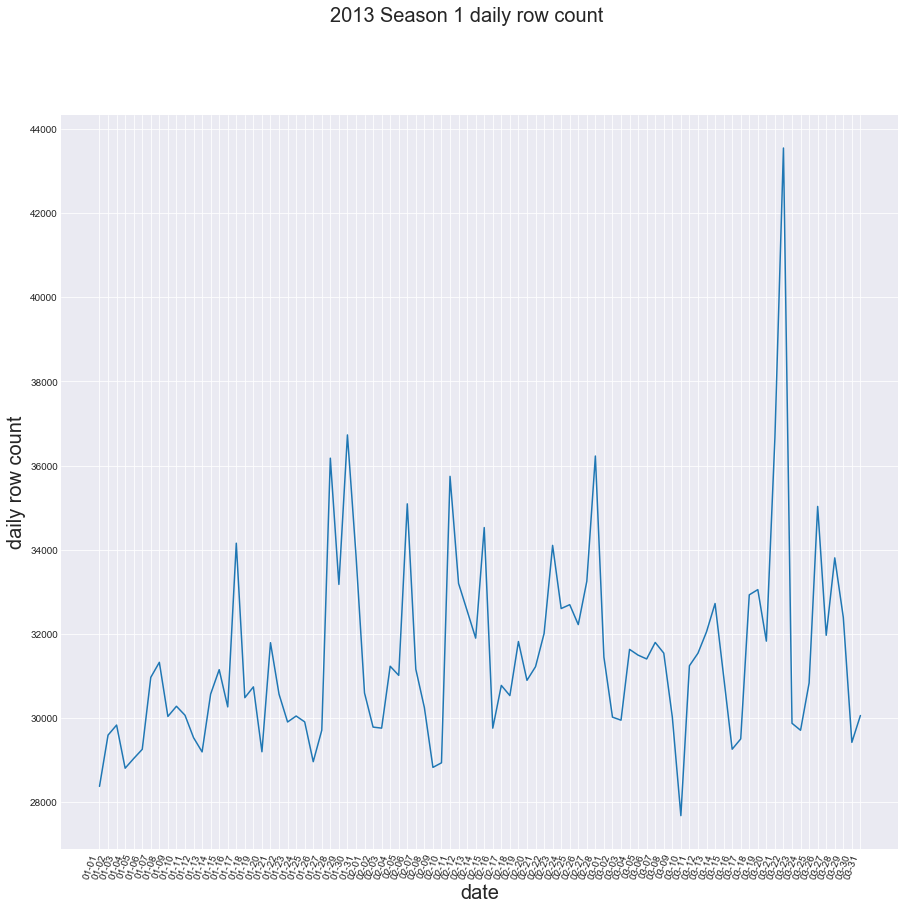

In [442]:
%matplotlib inline
sns.set_style("darkgrid")
fig= plt.figure(figsize=(15,15))
plt.plot(q1_2013['DATE'],q1_2013['COUNT(*)'])
fig.suptitle('2013 Season 1 daily row count',fontsize=20)
plt.xlabel("date",fontsize=20)
plt.ylabel("daily row count",fontsize=20)
fig.autofmt_xdate(bottom=0.2, rotation=70, ha='right')



 ### q2 plot daily busyness

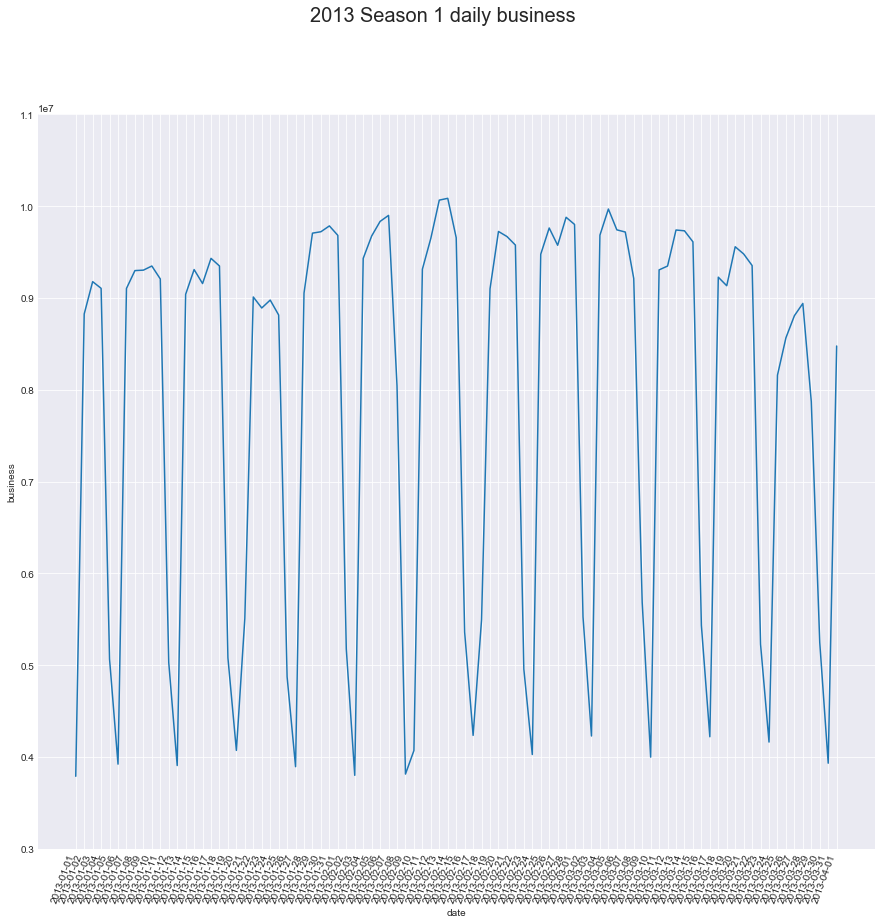

In [358]:
%matplotlib inline
data_2013_df.groupby(['DATE'])['busy'].sum().to_frame().reset_index()
q1_busy=data_2013_df.groupby(['DATE'])['busy'].sum().to_frame().reset_index()
q1_busy=q1_busy.loc[q1_busy['DATE']<='2013-04-01']
sns.set_style("darkgrid")
fig = plt.figure(figsize=(15,15))
plt.plot(q1_busy['DATE'],q1_busy['busy'])
fig.suptitle('2013 Season 1 daily business',fontsize=20)
plt.xlabel('date')
plt.ylabel('business')
plt.ylim([3000000,11000000])
fig.autofmt_xdate(bottom=0.2, rotation=70, ha='right')



 ### q3 plot mean and standard deviation of Penn-station 34st

In [176]:
penn_station_data=data_2013_df.loc[(data_2013_df['DATE']<'2013-04-01')&(data_2013_df['UNIT']=='R012')]
penn_station_monthly_data=penn_station_data.groupby('DATE')['busy'].sum().reset_index()
penn_station_monthly_data['month']=[x[6] for x in penn_station_monthly_data['DATE']]

Text(0,0.5,'busyness')

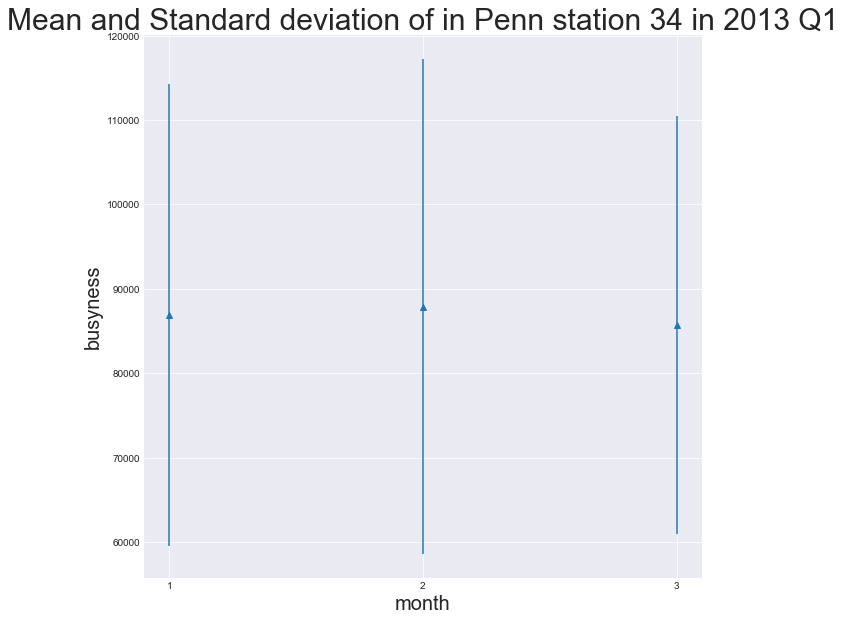

In [197]:
%matplotlib inline

f, ax = plt.subplots(figsize=(10, 10))
penn_station_monthly=penn_station_monthly_data.groupby('month')['busy'].agg([np.mean,np.std]).reset_index()
plt.errorbar(penn_station_monthly['month'], penn_station_monthly['mean'],
             penn_station_monthly['std'], linestyle='None', marker='^')
ax.set_xlabel("month",fontsize=20)
ax.set_title("Mean and Standard deviation of in Penn station 34 in 2013 Q1",fontsize=30)
ax.set_ylabel("busyness",fontsize=20)



 ### q4 quantiles of Penn-station 34st

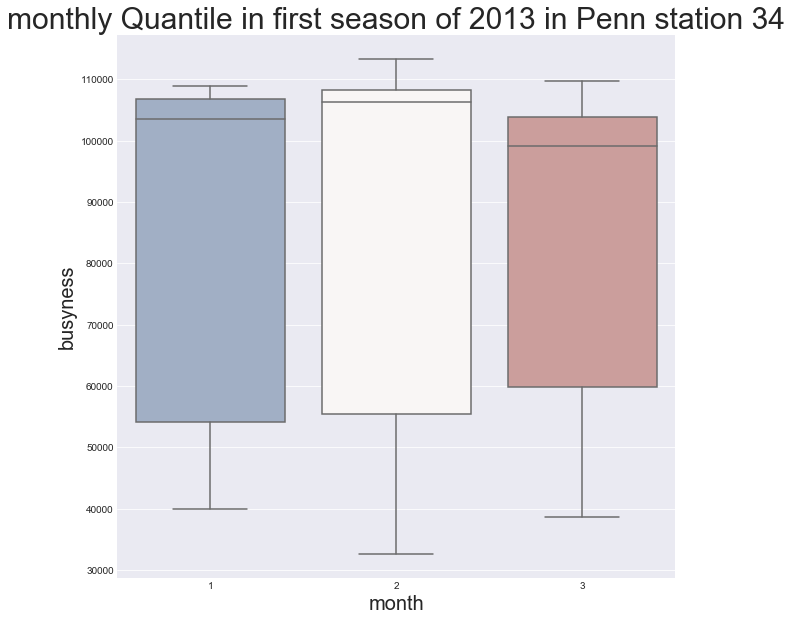

In [198]:
f, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x="month", y="busy", data=penn_station_monthly_data,
            whis=np.inf, palette="vlag")
ax.set_xlabel("month",fontsize=20)
ax.set_title("monthly Quantile in first season of 2013 in Penn station 34",fontsize=30)
ax.set_ylabel("busyness",fontsize=20)
print(penn_quantile)

 ### q5 daily closed station

In [428]:
close_df=data_2013_df.loc[(data_2013_df['entrie']==0)&(data_2013_df['exit']==0),:]
close_df=close_df.loc[close_df['DATE']<'2013-04-01',:]



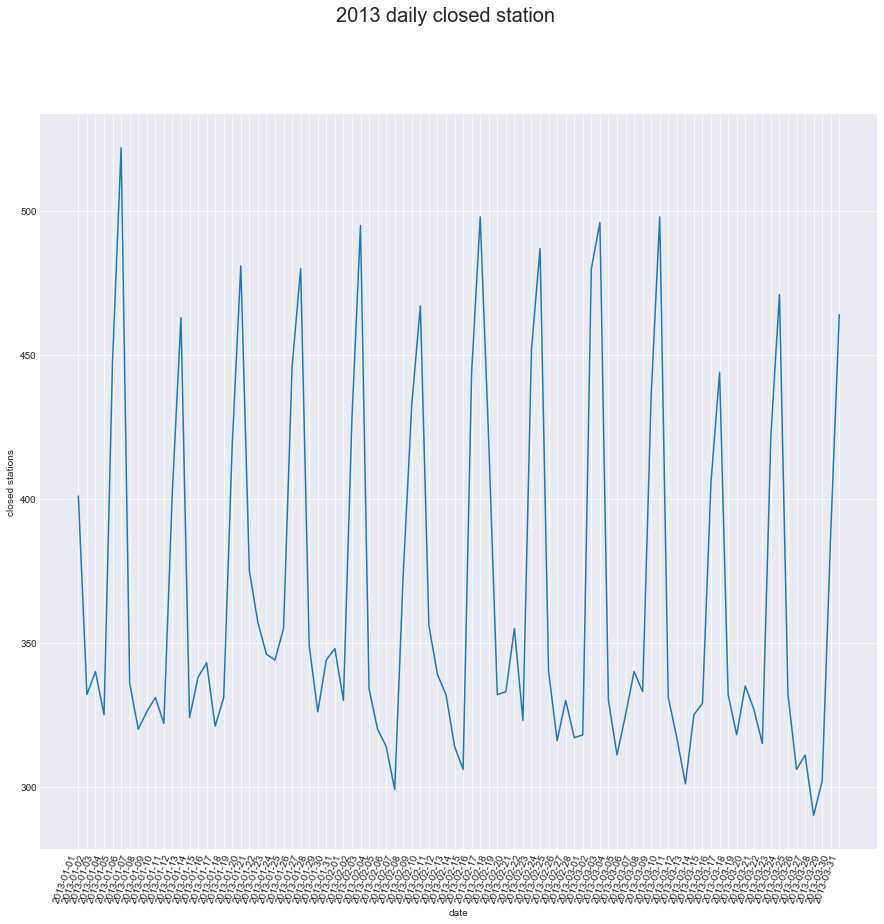

In [429]:
close_df=close_df.groupby('DATE')['CA','UNIT'].count().reset_index()
sns.set_style("darkgrid")
fig = plt.figure(figsize=(15,15))
plt.plot(close_df['DATE'],close_df['UNIT'])
fig.suptitle('2013 daily closed station',fontsize=20)
plt.xlabel('date')
plt.ylabel('closed stations')
fig.autofmt_xdate(bottom=0.2, rotation=70, ha='right')